### Лабораторная работа №4
####  Исследование абсолютно-оптимальных рекуррентных алгоритмов

Для оценки эффективности абсолютно-оптимальных алгоритмов рассмотрим задачу идентификации параметров линейного регрессионного объекта вида:
\begin{equation}y(i)=с_{0}+с_{1}u_{1}(i)+...+с_{4}u_{4}(i)+\eta(i)\end{equation}

Пусть шум измерений $\eta(i)$ имеет распределение Коши:
\begin{equation*}
f(\eta)=\frac{1}{\pi s}\frac{1}{(1+(\eta/s)^2)}
\end{equation*}

In [369]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import math

In [370]:
# параметры объекта 
c0 = 1.5
c1 = 2.5
c2 = -3.5
c3 = 4.5
c4 = 5
c = [c0, c1, c2, c3, c4]

In [371]:
# количество измерений
N = 200

In [372]:
np.random.seed(42)

In [373]:
# параметр распределения Коши
s = 0.1

In [374]:
Noise = st.cauchy.rvs(loc=0, scale=s, size=N)

In [375]:
Avg_U1 = 1
Var_U1 = 50
Avg_U2 = 1
Var_U2 = 50
Avg_U3 = 1
Var_U3 = 50
Avg_U4 = 1
Var_U4 = 50

In [376]:
# моделирование входов объекта
U1 = np.random.normal(Avg_U1, Var_U1, size=N)
U2 = np.random.normal(Avg_U2, Var_U2, size=N)
U3 = np.random.normal(Avg_U3, Var_U3, size=N)
U4 = np.random.normal(Avg_U4, Var_U4, size=N)

In [377]:
# моделирование выхода объекта
y = c0 + c1*U1 + c2*U2 + c3*U3 + c4*U4 + Noise

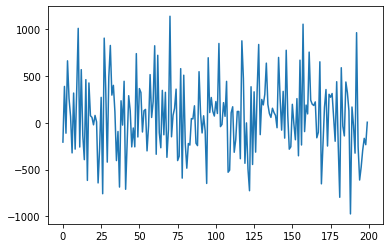

In [378]:
plt.plot(y)
plt.show()

#### Формирование алгоритма идентификации

В зависимости от того, насколько хорошо изучен «объект» идентификации, могут возникнуть следующие ситуации:

1. Объект изучен хорошо, правильно определена плотность распределения шума, т.е. принятая и реальная плотности распределения совпадают и на основе принятой функции распределения формируется оптимальная функция потерь.


2. Объект изучен плохо. При этом, как правило, считают, что плотность распределения шума соответствует нормальному закону распределения, хотя на самом деле(в данном случаем, см. описание объекта выше) шум имеет распределение Коши. Таким образом, опираясь на ложную гипотезу о нормальном распределении шума, в качестве функции потерь выбирается квадратичная функция.

Предлагается реализовать абсолютно-оптимальный рекуррентный алгоритм оценивания параметров объекта для каждой из ситуаций. Для   оценки   эффективности использования абсолютно-оптимальных  рекуррентных  алгоритмов  проводилось сравнение сглаженной ошибки оценки параметров объекта,определенных когда объект изучили хорошо и когда плохо, при  различных  значениях  параметра  распределения Коши — s.

#### В первом случае рекуррентный алгоритм принимает вид:
\begin{equation}\hat{\vec{c}}(i)=\hat{\vec{c}}(i-1)+Г(i)\frac{2(y(i)-\hat{c}_{0}(i-1)u_{0}(i)-...-\hat{c}_{4}(i-1)u_{4}(i))}{s^2+(y(i)-\hat{c}_{0}(i-1)u_{0}(i)-...-\hat{c}_{4}(i-1)u_{4}(i))^2}\vec{z}(i) \\
Г(i)=Г(i-1)-\frac{Г(i-1)\vec{z}(i)\vec{z}(i)^TГ(i-1)}{2s^2+\vec{z}^T(i)Г(i-1)\vec{z}(i)} \\
Г(0)=\lambda I, \lambda=0.1\\
\hat{\vec{c}}(0)=\vec{c}_{0}\end{equation}

In [365]:
Lambda = 0.1
I = np.eye(5)

Gamma = [None]*N
c_hat1 = [None]*N
c_hat2 = [None]*N
err = [None]*N

c_hat1[0] = c_hat2[0] = np.array([c0, c1, c2, c3, c4]).reshape(-1, 1)

Gamma[0] = Lambda*I

In [366]:
for i in range(1, N):
    z = np.array([1, U1[i], U2[i], U3[i], U4[i]]).reshape(-1, 1)
    err[i] = y[i] - (c_hat1[i-1].T@z)[0][0]
    Gamma[i] = Gamma[i-1] - (Gamma[i-1]@z@z.T@Gamma[i-1]) / (2 * s**2 + z.T@Gamma[i-1]@z)
    c_hat1[i] = c_hat1[i-1] + Gamma[i] * (2*err[i] / (s**2 + err[i]**2))@z
c_hat1[-1]

array([[ 1.30534422],
       [ 2.50415037],
       [-3.51008566],
       [ 4.50861077],
       [ 4.99988536]])

#### Во втором случае рекуррентный алгоритм принимает вид:
\begin{equation}\hat{\vec{c}}(i)=\hat{\vec{c}}(i-1)+Г(i)\vec{z}(i)(y(i)-\hat{c}_{0}(i-1)u_{0}(i)-...-\hat{c}_{4}(i-1)u_{4}(i)) \\
Г(i)=Г(i-1)-\frac{Г(i-1)\vec{z}(i)\vec{z}(i)^TГ(i-1)}{1+\vec{z}^T(i)Г(i-1)\vec{z}(i)} \\
Г(0)=\lambda I , \lambda=0.1    \\
\hat{\vec{c}}(0)=\vec{c}_{0}\end{equation}

In [367]:
for i in range(1, N):
    z = np.array([1, U1[i], U2[i], U3[i], U4[i]]).reshape(-1, 1)
    err[i] = y[i] - (c_hat2[i-1].T@z)[0][0]
    Gamma[i] = Gamma[i-1] - (Gamma[i-1]@z@z.T@Gamma[i-1]) / (1 + z.T@Gamma[i-1]@z)
    c_hat2[i] = c_hat2[i-1] + Gamma[i]@z * err[i]
c_hat2[-1]

array([[ 1.45431274],
       [ 2.49926982],
       [-3.49965529],
       [ 4.49838915],
       [ 4.99996872]])

Сглаженная ошибка оценки вычисляется по формуле:
\begin{equation*}
err_{сгл}=\sqrt{\frac{\sum_{j=1}^{10}\sum_{k=0}^4(\hat{c}_{k}(i-j)-c_{k})^2}{10}} ; i=10,11,12...
\end{equation*}

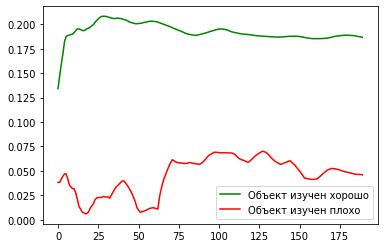

In [368]:
err1 = []*(N-10)
err2 = []
for i in range(10, N):
    sum1 = 0
    sum2 = 0
    for j in range(1, 10):
        for k in range(0, 4):
            sum1 += (c_hat1[i-j][k] - c[k])**2
            sum2 += (c_hat2[i-j][k] - c[k])**2
    err1.append(math.sqrt(sum1/10))
    err2.append(math.sqrt(sum2/10))
plt.plot(err1,color = 'g',label='Объект изучен хорошо')
plt.plot(err2,color = 'r',label='Объект изучен плохо')
plt.legend()